In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [16]:
raw_data = pd.read_csv('Data/house_data_details_cleaned.csv')
df = raw_data.copy()

In [17]:
#profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
#profile.to_file("RealEstateAVM_ProfileReport.html")

In [18]:
df.head()

,longitude,latitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,date,sale_price,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school quality,url,bedrooms,bathrooms
0,-118.13368,33.97462,6224 Nye St,Condominium,1357.00000,22215.60000,1988.00000,6357012043,1111054477.00000,Los Angeles,45351,1.00000,532304.00000,1,CMR3,9/28/20,469000.00000,439000.00000,7,High,15,1,Average,https://www.realtytrac.com/property/ca/commerc...,3.00000,3.00000
1,-118.39689,34.15656,4723 Laurel Canyon Blvd,Restaurant,2250.00000,9799.00000,1959.00000,2356037034,1111055289.00000,Los Angeles,7360,1.00000,143400.00000,10,LAC2,9/28/20,1910000.00000,nan,5,NaN,6,1,Excellent,https://www.realtytrac.com/property/ca/valley-...,nan,nan
2,-118.45116,34.67778,18118 Elizabeth Lake Rd,Apartment house (5+ units),1454.00000,13635.00000,1948.00000,3242015023,1111055911.00000,Los Angeles,NaN,2.00000,920102.00000,4,LCC4*,9/28/20,325000.00000,nan,0,NaN,2,1,NaN,https://www.realtytrac.com/property/ca/lake-hu...,7.00000,6.00000
3,-118.06690,34.07296,9259 Ramona Blvd,Single Family Residence,1682.00000,7000.00000,1978.00000,8594027016,1111055994.00000,Los Angeles,ROSEMEAD,2.00000,432901.00000,6,RMPOD*,9/28/20,738000.00000,752000.00000,3,Moderate,11,1,Excellent,https://www.realtytrac.com/property/ca/rosemea...,3.00000,2.00000
4,-118.15491,33.77772,825 Obispo Ave,"Triplex (3 units, any combination)",1958.00000,6754.00000,1938.00000,7258013016,1111056010.00000,Los Angeles,1,2.00000,576904.00000,18,LBR2N,9/28/20,1185000.00000,989000.00000,11,Slightly High,8,1,Average,https://www.realtytrac.com/property/ca/long-be...,4.00000,3.00000


In [185]:
df.describe()

,longitude,latitude,home_size,lot_size,year_built,parcel_number,realtyID,census,tract,sale_price,estimated_value,sex_offenders,enviornmental_hazards,natural_disasters,bedrooms,bathrooms
count,2735.00000,2735.00000,2641.00000,2725.00000,2663.00000,2770.00000,2769.00000,2738.00000,2738.00000,2673.00000,2524.00000,2770.00000,2770.00000,2770.00000,2552.00000,2552.00000
mean,-118.27296,34.11499,2390.78781,41742.12888,1964.18926,4999319848.46426,1110925213.89671,2.02374,439026.61870,1098161.30004,870009.11252,7.19711,7.04152,1.19567,3.36089,2.61364
std,0.21560,0.22297,5550.63114,267740.00302,26.59174,2126551959.33718,101297.29001,1.11807,261152.49314,2232478.70444,516122.69785,12.31339,6.93759,0.43333,2.99095,2.98152
min,-118.86073,33.33958,240.00000,745.00000,1890.00000,2004009012.00000,1110722482.00000,1.00000,0.00000,1000.00000,125000.00000,0.00000,1.00000,0.00000,1.00000,1.00000
25%,-118.43293,33.97703,1243.00000,6031.00000,1948.00000,2861051091.25000,1110849233.00000,1.00000,202325.00000,500000.00000,539000.00000,1.00000,3.00000,1.00000,2.00000,2.00000
50%,-118.29970,34.09186,1624.00000,7650.00000,1961.00000,5065015519.00000,1110893129.00000,2.00000,408004.00000,700000.00000,702000.00000,4.00000,5.00000,1.00000,3.00000,2.00000
75%,-118.12983,34.19707,2279.00000,16363.00000,1984.00000,7137007278.25000,1111016244.00000,3.00000,601901.50000,1099000.00000,1028000.00000,9.00000,8.00000,1.00000,4.00000,3.00000
max,-117.69579,34.81875,136778.40000,12486474.00000,2020.00000,8765016012.00000,1111084198.00000,8.00000,980008.00000,75454545.00000,2934000.00000,135.00000,84.00000,3.00000,96.00000,99.00000


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2770 entries, 0 to 2769
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   longitude              2735 non-null   float64
 1   latitude               2735 non-null   float64
 2   address                2765 non-null   object 
 3   property_type          2770 non-null   object 
 4   home_size              2641 non-null   float64
 5   lot_size               2725 non-null   float64
 6   year_built             2663 non-null   float64
 7   parcel_number          2770 non-null   int64  
 8   realtyID               2769 non-null   float64
 9   county                 2770 non-null   object 
 10  subdivision            2568 non-null   object 
 11  census                 2738 non-null   float64
 12  tract                  2738 non-null   float64
 13  lot                    2593 non-null   object 
 14  zoning                 2770 non-null   object 
 15  date

In [19]:
#Remove missing values for the target feature
df.dropna(inplace=True)
print(f'Number of observations before removing missing values: {raw_data.shape[0]}')
print(f'Number of observations after removing missing values: {df.shape[0]}')

Number of observations before removing missing values: 2770
Number of observations after removing missing values: 1840


In [20]:
#Convert date into a datetime object
df['date'] = pd.to_datetime(df['date'])

In [21]:
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df['date']

0      2069-09-19
1      2069-07-01
2      2067-12-13
3      2066-11-29
4      2065-01-11
          ...    
1835   1971-12-09
1836   1971-03-25
1837   1971-01-15
1838   1970-09-22
1839   1970-02-10
Name: date, Length: 1840, dtype: datetime64[ns]

In [22]:
#Correct the dates
df['date'] = df['date'].apply(lambda x: x.replace(year= x.year-100) if x.year>2020 else x)
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df['date']

0      2020-09-28
1      2020-09-28
2      2020-09-28
3      2020-09-28
4      2020-09-28
          ...    
1835   1969-09-19
1836   1969-07-01
1837   1967-12-13
1838   1966-11-29
1839   1965-01-11
Name: date, Length: 1840, dtype: datetime64[ns]

In [23]:
#Add a month and year column
df['month'] = df['date'].dt.to_period('M')
df['month']

0       2020-09
1       2020-09
2       2020-09
3       2020-09
4       2020-09
         ...   
1835    1969-09
1836    1969-07
1837    1967-12
1838    1966-11
1839    1965-01
Name: month, Length: 1840, dtype: period[M]

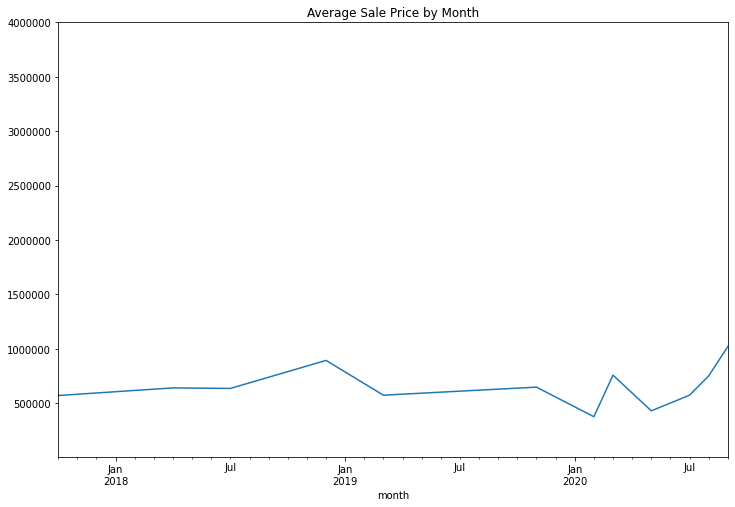

In [193]:
#Examine the trend of saleprice by month
df.groupby('month')['sale_price'].mean()[-12:].plot(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='y')
#plt.xlim('2015-01', df['month'].max())
plt.ylim(df['sale_price'].min(), 4000000)
plt.title('Average Sale Price by Month');

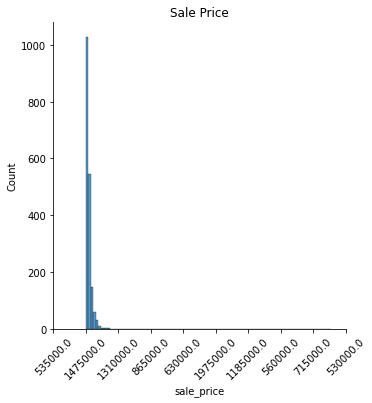

In [194]:
chart = sns.displot(df['sale_price'], bins=100)
plt.title('Sale Price')
plt.ticklabel_format(style='plain', axis='x')
chart.set(xticklabels=df['sale_price'])
chart.set_xticklabels(rotation=45);

In [24]:
#This function will identify the outlier boundaries for a variable

def find_skewed_boundaries(df, var, distance):
    
    IQR = df['sale_price'].quantile(.75) - df['sale_price'].quantile(.25)
    
    lower_boundary = df['sale_price'].quantile(.25) - (distance*IQR)
    upper_boundary = df['sale_price'].quantile(.75) + (distance*IQR)
    
    return upper_boundary, lower_boundary


sales_upper_boundary, sales_lower_boundary = find_skewed_boundaries(df, 'sale_price', 1.5)
print(sales_upper_boundary)

df_trimmed = df.loc[df['sale_price']<sales_upper_boundary,:]
print(f'Number of observations before removing outliers: {df.shape[0]}')
print(f'Number of observations after removing outliers: {df_trimmed.shape[0]}')

1960000.0
Number of observations before removing outliers: 1840
Number of observations after removing outliers: 1680


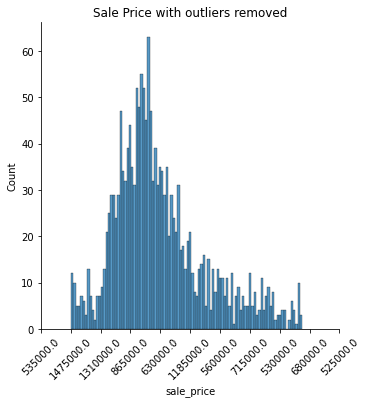

In [25]:
chart = sns.displot(df_trimmed['sale_price'], bins=100)
plt.title('Sale Price with outliers removed')
plt.ticklabel_format(style='plain', axis='x')
chart.set(xticklabels=df_trimmed['sale_price'])
chart.set_xticklabels(rotation=45);

In [26]:
temp = pd.concat([df_trimmed.groupby('property_type')['sale_price'].mean(), df_trimmed.groupby('property_type')['sale_price'].count(), df['property_type'].value_counts(normalize=True)], axis=1)
temp.columns = ['Average sale price', 'Count of property_type', 'Percentage of property type']
temp.sort_values(by=['Count of property_type'], axis=0,ascending=False, inplace=True)
print(f'Number of categories for property_type: {df_trimmed.property_type.nunique()}')
temp

Number of categories for property_type: 10


,Average sale price,Count of property_type,Percentage of property type
Single Family Residence,763881.27769,1210,0.72772
Condominium,640456.90657,289,0.16087
"Duplex (2 units, any combination)",775358.97059,68,0.03859
Planned Unit Development (PUD),681789.47368,57,0.03098
"Triplex (3 units, any combination)",842978.26087,23,0.01467
"Quadplex (4 Units, Any Combination)",1048968.75000,16,0.01141
Apartment house (5+ units),1238782.50000,14,0.01413
MISCELLANEOUS (Commercial),675000.00000,1,0.00054
"Religious, Church, Worship (Synagogue, Temple, Parsonage)",1500000.00000,1,0.00054
Residential - Vacant Land,493000.00000,1,0.00054


In [27]:
bad_prop_types = ['MISCELLANEOUS   (Commercial)', 'Religious, Church, Worship (Synagogue, Temple, Parsonage)', 'Residential - Vacant Land']
print(f'Number of observations before removing infrequent property types: {df_trimmed.shape[0]}')

for col in bad_prop_types:
    df_trimmed.drop(df_trimmed.index[df_trimmed['property_type']==col],  inplace=True)
    

print(f'Number of observations after removing infrequent property types: {df_trimmed.shape[0]}')

Number of observations before removing infrequent property types: 1680
Number of observations after removing infrequent property types: 1677


In [28]:
temp2 = pd.concat([df_trimmed.groupby('property_type')['sale_price'].mean(), df_trimmed.groupby('property_type')['sale_price'].count(), df['property_type'].value_counts(normalize=True)], axis=1)
temp2.columns = ['Average sale price', 'Count of property_type', 'Percentage of property type']
temp2.sort_values(by=['Average sale price'], axis=0,ascending=False, inplace=True)
print(f'Number of categories for property_type: {df_trimmed.property_type.nunique()}')
temp2

Number of categories for property_type: 7


,Average sale price,Count of property_type,Percentage of property type
Apartment house (5+ units),1238782.50000,14.00000,0.01413
"Quadplex (4 Units, Any Combination)",1048968.75000,16.00000,0.01141
"Triplex (3 units, any combination)",842978.26087,23.00000,0.01467
"Duplex (2 units, any combination)",775358.97059,68.00000,0.03859
Single Family Residence,763881.27769,1210.00000,0.72772
Planned Unit Development (PUD),681789.47368,57.00000,0.03098
Condominium,640456.90657,289.00000,0.16087
Residential - Vacant Land,nan,nan,0.00054
MISCELLANEOUS (Commercial),nan,nan,0.00054
"Religious, Church, Worship (Synagogue, Temple, Parsonage)",nan,nan,0.00054


<AxesSubplot:>

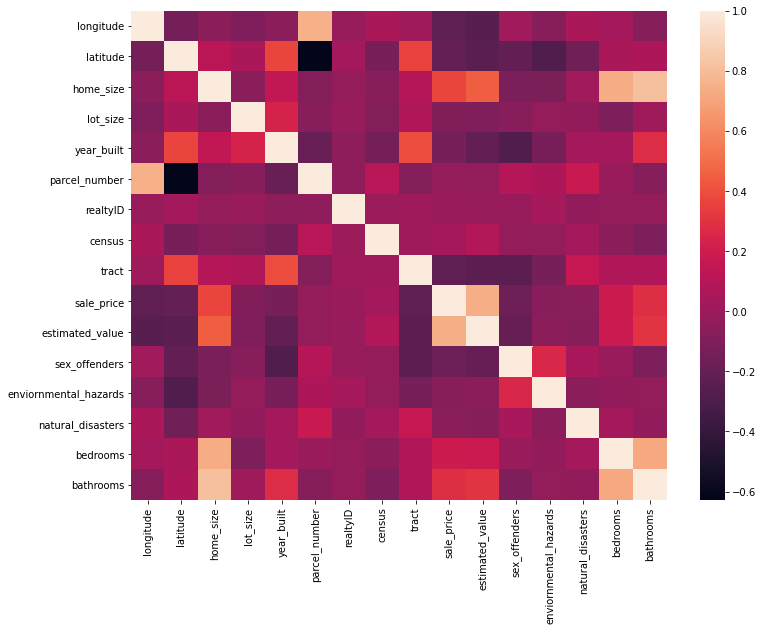

In [13]:
corrmat = df_trimmed.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat)

In [103]:
df.isnull().sum().sort_values(ascending=False)

crime_index              407
estimated_value          239
bathrooms                209
bedrooms                 209
subdivision              199
lot                      175
home_size                126
year_built               105
lot_size                  45
school quality            40
latitude                  34
longitude                 34
tract                     32
census                    32
address                    5
realtyID                   1
zoning                     0
date                       0
sale_price                 0
county                     0
parcel_number              0
sex_offenders              0
enviornmental_hazards      0
natural_disasters          0
property_type              0
url                        0
pra                        0
dtype: int64

In [108]:
temp = pd.concat([df.groupby('crime_index')['sale_price'].mean(), df.groupby('crime_index')['sale_price'].count()], axis=1)
temp.columns = ['Average sale price', 'Count of crime index']
temp

,Average sale price,Count of crime index
crime_index,,
High,1007000.00000,18
Low,940191.05556,684
Moderate,1009516.59125,663
Moderately High,738605.26316,57
Slightly High,1424125.22527,657
Very High,3714000.00000,3
Very Low,1084731.37500,184


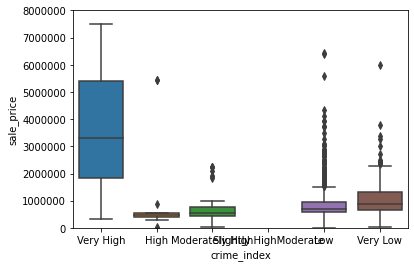

In [123]:
order=['Very High', 'High', 'Moderately High', 'Slightly High' 'Moderate', 'Low', 'Very Low']


boxplot = sns.boxplot(x='crime_index', y='sale_price', data=df, order=order)
plt.ylim(0,8000000)
plt.ticklabel_format(style='plain', axis='y')

In [109]:
np.sum(df2['Count of crime index'])

2266

In [110]:
df.shape

(2673, 27)

In [58]:
#df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
#df.index.freq = 'D'
#df.index

In [30]:
df_trimmed.to_csv('Data/house_data_details_eda.csv', index=False)